In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../../../devel/lib/python2.7/dist-packages')
sys.path.insert(0, '../../../src/merganser/packages/merganser_line_detector/include')
sys.path.insert(0, '../../../src/merganser/packages/merganser_bezier/include')

In [109]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import json

In [237]:
from merganser_bezier.bezier import Bezier, compute_curve
from merganser_bezier.kalman import KalmanFilter, rotation, block_diag
from merganser_bezier.utils.kinematics import transform

In [111]:
filename = 'skeletons_log_11-25_2.json'
with open(filename, 'rb') as f:
    skeletons_frames = json.load(f)

In [296]:
cloud = np.array(skeletons_frames[0]['white'][0]).T
cloud_ = cloud.copy()

In [297]:
len(cloud)

98

In [298]:
bezier = Bezier(4, 20, choice=cloud)
bezier.closed_form(cloud)

In [299]:
kalman = KalmanFilter(bezier.controls.reshape(-1), .01, .01)

<function matplotlib.pyplot.show>

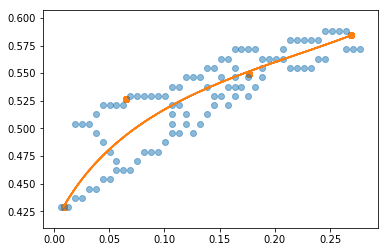

In [300]:
controls = np.random.multivariate_normal(bezier.controls.reshape(8), kalman.sigma, size=20).reshape(-1, 4, 2)

for control in controls:
    
    plt.plot(*compute_curve(control, 100).T, color='C1', alpha=.5)
    plt.scatter(*control.T, color='C1', alpha=.5)
    
plt.scatter(*cloud_.T, alpha=.5, color='C0')
plt.axis('equal')
plt.show

In [301]:
v, omega, dt = .2, 1.5, .1
dx = v * dt
dtheta = omega * dt

In [302]:
cloud_ = transform(-v, -omega, dt, cloud_) + .01 * np.random.normal(size=cloud.shape)

In [303]:
kalman.predict(dx, dtheta)
bezier.controls = kalman.mu

<function matplotlib.pyplot.show>

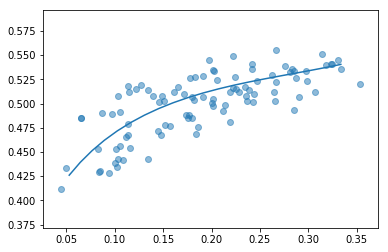

In [304]:
plt.plot(*bezier().T)
plt.scatter(*cloud_.T, alpha=.5)
plt.axis('equal')
plt.show

<function matplotlib.pyplot.show>

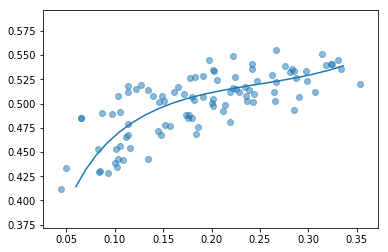

In [305]:
bezier.closed_form(cloud_)
plt.plot(*bezier().T)
plt.scatter(*cloud_.T, alpha=.5)
plt.axis('equal')
plt.show

In [287]:
kalman.correct(bezier, cloud)
bezier.controls = kalman.mu

<function matplotlib.pyplot.show>

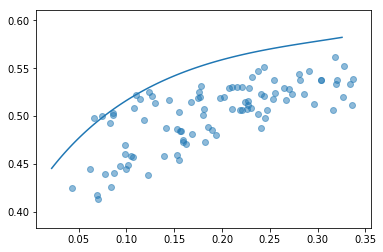

In [288]:
plt.plot(*compute_curve(kalman.mu, 100).T)
plt.scatter(*cloud_.T, alpha=.5)
plt.axis('equal')
plt.show

<function matplotlib.pyplot.show>

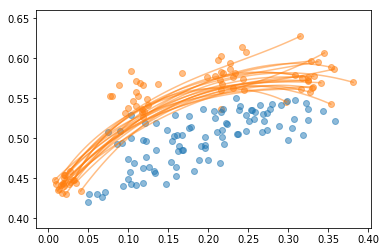

In [241]:
controls = np.random.multivariate_normal(
    bezier.controls.reshape(8), 
    kalman.sigma * block_diag(*[np.ones((2, 2)) for _ in range(4)]) * .1, 
    size=20
).reshape(-1, 4, 2)

for control in controls:
    
    plt.plot(*compute_curve(control, 100).T, color='C1', alpha=.5)
    plt.scatter(*control.T, color='C1', alpha=.5)
    
plt.scatter(*cloud_.T, alpha=.5, color='C0')
plt.axis('equal')
plt.show

In [ ]:
kalman.step(dx, dtheta, bezier, cloud)

In [ ]:
sigma_bar_inv

In [218]:
mu, sigma = kalman.correct(bezier, cloud, _mu, _sigma)

In [219]:
mu

array([ 0.01351352,  0.42886562,  0.0682157 ,  0.53270979,  0.18068034,
        0.55148583,  0.27483808,  0.58506358])

In [221]:
bezier.controls = mu.reshape(4, 2)

(-0.015851485158147015,
 0.28885602896839613,
 0.41795013787343566,
 0.59622711089210834)

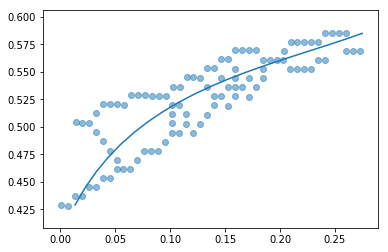

In [222]:
plt.plot(*bezier().T)
plt.scatter(*cloud_.T, alpha=.5)
plt.axis('equal')

In [167]:
_mu.reshape(4, 2)

array([[ 0.01448812,  0.42920759],
       [ 0.06961464,  0.52755123],
       [ 0.181488  ,  0.55113384],
       [ 0.2731285 ,  0.58681529]])

In [168]:
_sigma

array([[ 0.1,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0.1,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0.1,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0.1,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0.1,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1]])

In [169]:
bezier.controls = _mu.reshape(4, 2)
arg = ((bezier().reshape(1, -1, 2) - cloud.reshape((-1, 1, 2))) ** 2).sum(axis=2).argmin(axis=1)
b = bezier.bernstein[arg]
b = np.array([
    np.hstack([b__ * np.eye(2) for b__ in b_])
    for b_ in b
])

In [170]:
b.shape

(98, 2, 8)

In [197]:
btq_ = np.matmul(b.transpose(0, 2, 1), kalman.q_)

_sigma_ = np.linalg.inv(_sigma)

In [198]:
btq_.shape

(98, 8, 2)

In [173]:
sigma_ = np.matmul(btq_, b).sum(axis=0) + _sigma_

In [176]:
np.linalg.inv(sigma_).round(2)

array([[ 0.01,  0.  , -0.01,  0.  ,  0.01,  0.  , -0.  ,  0.  ],
       [ 0.  ,  0.01,  0.  , -0.01,  0.  ,  0.01,  0.  , -0.  ],
       [-0.01,  0.  ,  0.03,  0.  , -0.02,  0.  ,  0.01,  0.  ],
       [ 0.  , -0.01,  0.  ,  0.03,  0.  , -0.02,  0.  ,  0.01],
       [ 0.01,  0.  , -0.02,  0.  ,  0.03,  0.  , -0.01,  0.  ],
       [ 0.  ,  0.01,  0.  , -0.02,  0.  ,  0.03,  0.  , -0.01],
       [-0.  ,  0.  ,  0.01,  0.  , -0.01,  0.  ,  0.01,  0.  ],
       [ 0.  , -0.  ,  0.  ,  0.01,  0.  , -0.01,  0.  ,  0.01]])

In [180]:
np.matmul(btq_, cloud.reshape(-1, 2, 1)).sum(axis=0)

array([[  14.05609493],
       [ 106.08920449],
       [  29.14672103],
       [ 138.15500671],
       [  41.61374551],
       [ 145.16582983],
       [  46.88155231],
       [ 126.80843587]])

In [181]:
_sigma_

array([[ 10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  10.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  10.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  10.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  10.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,  10.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  10.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  10.]])

In [90]:
np.matmul(_sigma_, _mu)

array([ 0.1,  0. ,  0.1,  0. ,  0.1,  0. ,  0.1,  0. ])

In [188]:
np.matmul(btq_, cloud.reshape(-1, 2, 1)).sum(axis=0).reshape(-1)

array([  14.05609493,  106.08920449,   29.14672103,  138.15500671,
         41.61374551,  145.16582983,   46.88155231,  126.80843587])

In [189]:
np.matmul(_sigma_, _mu)

array([ 0.14488116,  4.29207591,  0.69614637,  5.27551225,  1.81488004,
        5.5113384 ,  2.73128504,  5.86815288])

In [190]:
np.matmul(btq_, cloud.reshape(-1, 2, 1)).sum(axis=0).reshape(-1) + np.matmul(_sigma_, _mu)

array([  14.2009761 ,  110.3812804 ,   29.8428674 ,  143.43051896,
         43.42862555,  150.67716823,   49.61283736,  132.67658874])

In [193]:
sigma.shape

(98, 8, 8)

In [191]:
np.matmul(sigma, np.matmul(btq_, cloud.reshape(-1, 2, 1)).sum(axis=0).reshape(-1) + np.matmul(_sigma_, _mu))

array([[  1.41659233,  11.02796252,   2.89490204,  14.08383113,
          3.58309258,  12.86434033,   2.80860215,   7.02475881],
       [  1.41969132,  11.03699631,   2.96234714,  14.28193852,
          3.94794984,  13.96767598,   2.59180744,   6.66741382],
       [  1.41969132,  11.03699631,   2.96234714,  14.28193852,
          3.94794984,  13.96767598,   2.59180744,   6.66741382],
       [  1.41969132,  11.03699631,   2.96234714,  14.28193852,
          3.94794984,  13.96767598,   2.59180744,   6.66741382],
       [  1.3904305 ,  10.94490919,   2.65053173,  13.29433983,
          3.09128125,  11.13504658,   3.3968071 ,   8.35182108],
       [  1.40776788,  11.00090912,   2.78701102,  13.74754911,
          3.2907254 ,  11.89170197,   3.09081769,   7.62141024],
       [  1.40776788,  11.00090912,   2.78701102,  13.74754911,
          3.2907254 ,  11.89170197,   3.09081769,   7.62141024],
       [  1.40776788,  11.00090912,   2.78701102,  13.74754911,
          3.2907254 ,  11.8917019

In [199]:
sigma_ = np.matmul(btq_, b).sum(axis=0) + _sigma_
sigma = np.linalg.inv(sigma_)

mu = np.matmul(sigma, np.matmul(btq_, cloud.reshape(-1, 2, 1)).sum(axis=0).reshape(-1) + np.matmul(_sigma_, _mu))

In [200]:
mu

array([ 0.01351352,  0.42886562,  0.0682157 ,  0.53270979,  0.18068034,
        0.55148583,  0.27483808,  0.58506358])

In [68]:
cloud.shape

(98, 2)

In [196]:
mu, sigma = kalman.correct(bezier, cloud, _mu, _sigma)

ValueError: shapes (98,8,2) and (98,8,2) not aligned: 2 (dim 2) != 8 (dim 1)

In [27]:
b = b.reshape(98, 1, 4)

In [28]:
np.matmul(cov_inv.reshape((1, 2, 2)), )

array([[[  1.45793847e-04,   7.87286776e-03,   1.41711620e-01,
           8.50269719e-01]],

       [[  1.45793847e-04,   7.87286776e-03,   1.41711620e-01,
           8.50269719e-01]],

       [[  1.45793847e-04,   7.87286776e-03,   1.41711620e-01,
           8.50269719e-01]],

       [[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           1.00000000e+00]],

       [[  3.93643388e-03,   6.29829421e-02,   3.35909025e-01,
           5.97171599e-01]],

       [[  3.93643388e-03,   6.29829421e-02,   3.35909025e-01,
           5.97171599e-01]],

       [[  3.93643388e-03,   6.29829421e-02,   3.35909025e-01,
           5.97171599e-01]],

       [[  1.16635078e-03,   2.97419449e-02,   2.52806532e-01,
           7.16285173e-01]],

       [[  1.16635078e-03,   2.97419449e-02,   2.52806532e-01,
           7.16285173e-01]],

       [[  3.14914711e-02,   2.04694562e-01,   4.43504884e-01,
           3.20309083e-01]],

       [[  3.14914711e-02,   2.04694562e-01,   4.43504884e-01,
       

In [10]:
cloud_ = cloud.copy()

(-0.015822382582964173,
 0.28882692639321328,
 0.41792660323882502,
 0.59625064552671914)

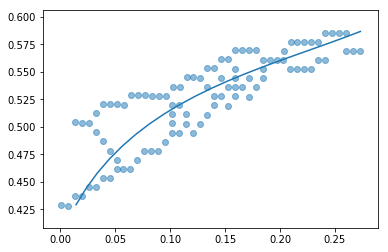

In [127]:
plt.plot(*bezier().T)
plt.scatter(*cloud_.T, alpha=.5)
plt.axis('equal')

In [18]:
cloud_ = transform(v, omega, dt, cloud_)
kalman.step(v, omega, dt, bezier, cloud_)
bezier.controls = kalman.mu

plt.plot(*bezier().T)
plt.scatter(*cloud_.T, alpha=.5)

ValueError: too many values to unpack

In [18]:
kalman.mu, kalman.sigma = kalman.predict(1, 0.1, 1)
kalman.mu

ValueError: axes don't match array

In [26]:
kalman.sigma

array([[[ 2.3,  0. ],
        [ 0. ,  2.3]],

       [[ 2.3,  0. ],
        [ 0. ,  2.3]],

       [[ 2.3,  0. ],
        [ 0. ,  2.3]],

       [[ 2.3,  0. ],
        [ 0. ,  2.3]]])

In [19]:
t = kalman.sigma * np.arange(1, 5).reshape(-1, 1, 1)

In [21]:
t

array([[[ 1.,  0.],
        [ 0.,  1.]],

       [[ 2.,  0.],
        [ 0.,  2.]],

       [[ 3.,  0.],
        [ 0.,  3.]],

       [[ 4.,  0.],
        [ 0.,  4.]]])

In [23]:
np.matmul(t, np.eye(2, 2))

array([[[ 1.,  0.],
        [ 0.,  1.]],

       [[ 2.,  0.],
        [ 0.,  2.]],

       [[ 3.,  0.],
        [ 0.,  3.]],

       [[ 4.,  0.],
        [ 0.,  4.]]])

In [20]:
kalman.process_noise + kalman.sigma

array([[[ 1.1,  0. ],
        [ 0. ,  1.1]],

       [[ 1.1,  0. ],
        [ 0. ,  1.1]],

       [[ 1.1,  0. ],
        [ 0. ,  1.1]],

       [[ 1.1,  0. ],
        [ 0. ,  1.1]]])

In [27]:
bezier = Bezier(4, 100, choice=cloud)

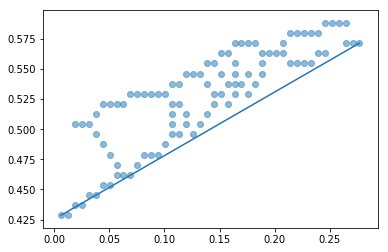

In [28]:
plt.plot(*bezier().T)
plt.scatter(*cloud.T, alpha=.5)

In [45]:
bezier = Bezier(4, 20, choice=cloud)
bezier.closed_form(cloud)

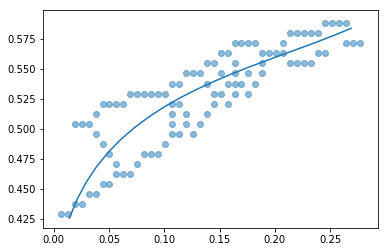

In [53]:
plt.plot(*bezier().T)
plt.scatter(*cloud.T, alpha=.5)

In [36]:
arg = ((bezier().reshape(1, -1, 2) - cloud.reshape(-1, 1, 2)) ** 2).sum(axis=2).argmin(axis=1)

In [37]:
arg

array([18, 18, 18, 19, 16, 16, 16, 17, 17, 13, 13, 13, 14, 15, 18, 19, 19,
       12, 12, 14, 14, 15, 15, 17, 17, 11, 11, 12, 14, 15, 15, 16, 16, 10,
       10, 10, 11, 12, 13, 13,  9,  9, 10, 11, 12, 12, 13,  7,  7,  7,  7,
        8,  8, 11, 11, 12, 12,  5,  5,  6,  6,  8,  9, 10, 11,  5,  8,  9,
       10,  4,  4,  4,  8,  8,  9,  4,  7,  8,  9,  4,  7,  4,  5,  6,  6,
        4,  5,  3,  4,  4,  2,  3,  2,  2,  1,  1,  0,  0])

In [56]:
b = bezier.bernstein[arg]

In [57]:
cov = np.cov((np.matmul(b, bezier.controls) - cloud).T).reshape(1, 2, 2) * np.ones((4, 1, 1))

In [58]:
cov

array([[[ 0.00011206, -0.00012516],
        [-0.00012516,  0.00020877]],

       [[ 0.00011206, -0.00012516],
        [-0.00012516,  0.00020877]],

       [[ 0.00011206, -0.00012516],
        [-0.00012516,  0.00020877]],

       [[ 0.00011206, -0.00012516],
        [-0.00012516,  0.00020877]]])

In [53]:
bezier = Bezier(4, 20, choice=cloud)

bezier.closed_form(cloud)
bezier.closed_form(cloud)
bezier.closed_form(cloud)
bezier.closed_form(cloud)

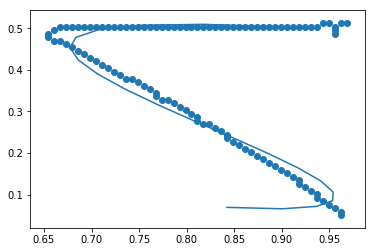

In [54]:
plt.plot(*bezier().T)
plt.scatter(*cloud.T)

In [ ]:
%%timeit
bezier = Bezier(4, 100, choice=cloud)
bezier.closed_form(cloud)

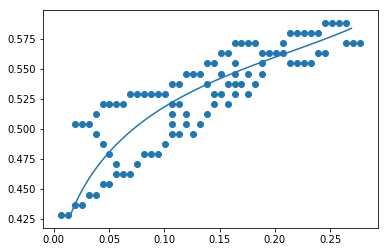

In [39]:
params = bezier.closed_form(cloud)
bezier.controls = params
plt.plot(*bezier().T)
plt.scatter(*cloud.T)

In [31]:
params

array([[ 0.00419374,  0.42452775],
       [ 0.0656851 ,  0.52608448],
       [ 0.16880441,  0.5469147 ],
       [ 0.26626558,  0.58344595]])

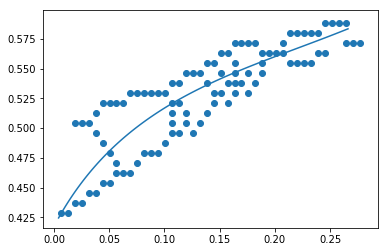

In [32]:
plt.plot(*compute_curve(params).T)
plt.scatter(*cloud.T)

In [40]:
bezier.nll(cloud)

0.031189449902748516

In [30]:
class BezierWrapper:
    
    def __init__(self):
        
        self.beziers = dict(red=[], yellow=[], white=[])
        
        self.curve_precision = 20
        self.reg = .01
        self.eps = .001
        self.lr = .01
        self.fitting_steps = 100
        self.loss_threshold = .001
        
    def process_cloud(self, cloud, color):
        
        choice = np.linspace(.2, .8, 4).reshape(-1, 1)
        choice = np.hstack((choice, choice))
        
        beziers = self.beziers[color]
        
        losses = np.array([b.loss(cloud) for b in beziers])
        argmin = losses.argmin() if len(losses) > 0 else -1

        if argmin > -1 and losses[argmin] < self.loss_threshold:
            bezier = beziers[argmin].copy()
        else:
            bezier = Bezier(4, self.curve_precision, choice=cloud, reg=self.reg)
        
#         bezier.extrapolate(-.05, 1.05)
            
        bezier.fit(
            cloud=cloud,
            steps=self.fitting_steps,
            eps=self.eps,
            lr=self.lr,
        )
        
        return bezier, color
    
    def process_clouds(self, skeletons):
        pass

In [31]:
bw = BezierWrapper()

In [48]:
def plot_skeletons(skeletons, save=''):
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_facecolor('black')
    
    plt.xlim(0, 1)
    plt.ylim(0, .8)
    
    for color in ['white', 'yellow', 'red']:
        beziers = []
        for skeleton in skeletons[color]:
            
            cloud = np.array(skeleton).T

            if len(cloud) < 20:
                continue

            b, c = bw.process_cloud(cloud, color)
            
            beziers.append(b)
            
#             plt.plot(*b().T, lw=5, color='black')
            plt.plot(*b().T, lw=5, color=color)
            plt.scatter(*cloud.T, alpha=.5, c=color)
        
        bw.beziers[color] = beziers
    
    if save:
        plt.savefig(save, bbox_inches='tight', dpi=200)
        plt.close()
        
    else:
        plt.show()

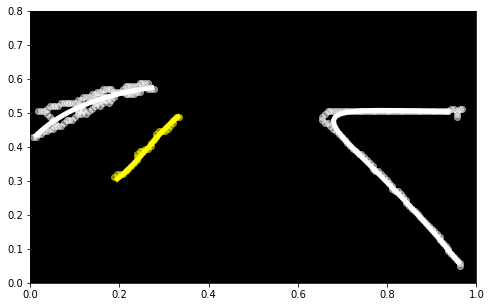

In [49]:
plot_skeletons(skeletons_frames[0]) #, 'output/skeletons_1.png')

In [46]:
from tqdm import tqdm

In [50]:
for i, skeletons in enumerate(tqdm(skeletons_frames[150:], ascii=True, ncols=100)):
    plot_skeletons(skeletons, 'output/skeletons3/skeletons_%03d.png' % (i, ))

100%|#############################################################| 833/833 [17:37<00:00,  1.27s/it]
